In [1]:
import time

import numpy as np
import mediapipe as mp
import cv2

In [165]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

def draw_styled_landmarks(image, results):
    # Draw face connections

    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             )
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )
    # Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )

In [166]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while True:
        ret, frame = cap.read()
        if not ret:
            print('Failed to capture frame')
            exit(1)
        image, results = mediapipe_detection(frame, holistic)
        draw_styled_landmarks(image, results)
        cv2.imshow('frame', image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [4]:
lh = np.array([[res.x, res.y, res.visibility] for res in results.left_hand_landmarks.landmark]) if results.left_hand_landmarks else np.zeros(21*3)
lh[0]

0.0

In [45]:
def plot(x, y):
    import matplotlib.pyplot as plt

    # plot the left hand landmarks
    fig, ax = plt.subplots(1, 1)
    ax.scatter(x, y, marker='o', s=10)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Left Hand Landmarks')

    # make the scale of the plot consistent
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    plt.show()

In [173]:
lh = np.array([[res.x, res.y] for res in results.left_hand_landmarks.landmark]) if results.left_hand_landmarks else None
rh = np.array([[res.x, res.y] for res in results.right_hand_landmarks.landmark]) if results.right_hand_landmarks else None

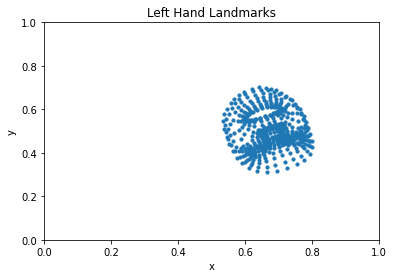

In [178]:
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]) if results.face_landmarks else np.zeros(468*3)
plot(face[:,0], face[:,1])

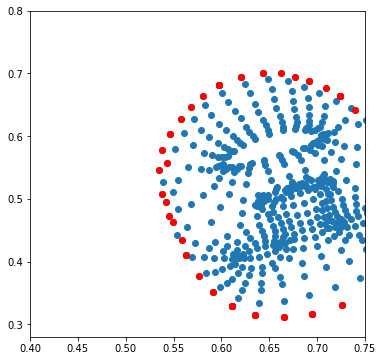

In [202]:
x_min = np.min(face[:,0])
x_max = np.max(face[:,0])
y_min = np.min(face[:,1])
y_max = np.max(face[:,1])

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot()

# plot a rectangle around the face
ax.plot(face[:,0], face[:,1], 'o')

closest_points = []

for y in np.linspace(y_min,y_max,20):
    closest_points.append(np.argmin(np.abs(face[:,0] - x_min) + np.abs(face[:,1] - y)))
    closest_points.append(np.argmin(np.abs(face[:,0] - x_max) + np.abs(face[:,1] - y)))

for x in np.linspace(x_min,x_max,20):
    closest_points.append(np.argmin(np.abs(face[:,0] - x) + np.abs(face[:,1] - y_max)))
    closest_points.append(np.argmin(np.abs(face[:,0] - x) + np.abs(face[:,1] - y_min)))

for i in closest_points:
    plt.plot(face[i,0], face[i,1], 'o', color='r')

plt.xlim(.40, 0.75)
plt.ylim(0.28, 0.8)
plt.show()

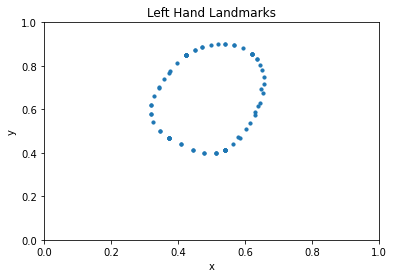

In [111]:
from IPython.core.display_functions import clear_output

arr = np.array([[face[i,0], face[i,1]] for i in closest_points])

max_x = np.max(arr[:,0])###########################
max_y = np.max(arr[:,1])
min_x = np.min(arr[:,0])
min_y = np.min(arr[:,1])

arr2 = arr.copy()
arr2[:,1] = arr[:,1] + (1 - max_y)
np.max(arr2[:,1])

# random number between  (- min) and (1-max)
import numpy.random as r

# 1 > (1-max)
# 0 > min

# 1 = 0.2
# 0 = -0.4

for i in range(10):
    clear_output(wait=True)
    ra = r.random(1)[0]
    random_movement_x = (r.random(1)[0] * (min_x + (1-max_x))) - min_x
    random_movement_y = (r.random(1)[0] * (min_y + (1-max_y))) - min_y

    plot(arr[:,0] + random_movement_x, arr[:,1] + random_movement_y)
    time.sleep(1)




# max move to left -> arr[:,1] - min_y

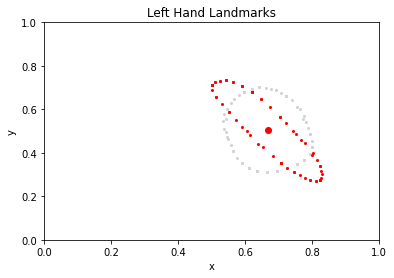

In [204]:
import matplotlib.pyplot as plt
import math

angle = 10

arr = np.array([[face[i,0], face[i,1]] for i in closest_points])

fig, ax = plt.subplots(1, 1)
center = np.average(arr[:,0]), np.average(arr[:,1])
ax.scatter(arr[:,0], arr[:,1], marker='o', s=4, c="lightgray")

# rotate the points around the center by angle degrees
arr[:,0] = arr[:,0] - center[0]
arr[:,1] = arr[:,1] - center[1]

# rotate the points around the center by angle degrees
arr[:,0] = arr[:,0] * math.cos(angle) - arr[:,1] * math.sin(angle)
arr[:,1] = arr[:,0] * math.sin(angle) + arr[:,1] * math.cos(angle)

# rotate the points around the center by angle degrees
arr[:,0] = arr[:,0] + center[0]
arr[:,1] = arr[:,1] + center[1]

# plot the rotated points
ax.scatter(arr[:,0], arr[:,1], marker='o', s=4, c="red")

ax.scatter(center[0], center[1], c="red")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Left Hand Landmarks')

# make the scale of the plot consistent
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.show()


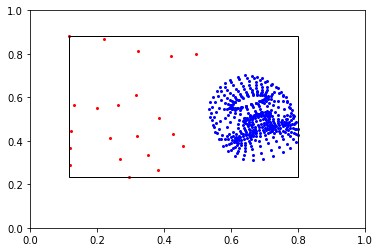

In [194]:
# face = np.array([[face[i,0], face[i,1]] for i in closest_points])

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

face2 = np.array([[x[0], x[1]] for x in face])
conc = np.concatenate([face2, rh])

ax.scatter(face2[:,0], face2[:,1], marker='o', s=4, c="blue")
ax.scatter(rh[:,0], rh[:,1], marker='o', s=4, c="red")

from matplotlib.patches import Rectangle

rect = Rectangle(
    xy=(np.min(conc[:,0]), np.min(conc[:,1])),
    width=np.max(conc[:,0]) - np.min(conc[:,0]),
    height=np.max(conc[:,1]) - np.min(conc[:,1]),
    fill=None
)

ax.add_patch(rect)

plt.xlim(0,1)
plt.ylim(0,1)
plt.show()


In [174]:
conc = np.concatenate(face, )

array([[0.11605249, 0.88389742],
       [0.21941204, 0.86904621],
       [0.32375419, 0.81396854],
       [0.41953868, 0.79125023],
       [0.49415454, 0.79990524],
       [0.31763542, 0.61234182],
       [0.38555834, 0.50323296],
       [0.42603064, 0.4315711 ],
       [0.45804873, 0.37516534],
       [0.26347101, 0.56644386],
       [0.31864741, 0.42434043],
       [0.35333514, 0.33654279],
       [0.38248411, 0.26400471],
       [0.20137659, 0.55191922],
       [0.24003682, 0.41117197],
       [0.26858959, 0.31613925],
       [0.29526675, 0.23428404],
       [0.13194865, 0.56269777],
       [0.12364019, 0.44713062],
       [0.11801748, 0.36722052],
       [0.11962485, 0.28944638]])

In [191]:
face2 = np.array([[x[0], x[1]] for x in face])
conc = np.concatenate([face2, rh])
np.min(conc[:,0])

0.11605249345302582